# <center> Project: Identification of internet users based on their internet behavior

## <center> Alexey Kuritsyn (c) 2017

## Introduction / Problem statement
In this project we will be solving a problem of user identification based on their behavior on the Internet. This is a complex and interesting problem at a junction of data science and behavioral phsycology. For example, many email providers are trying to identify email hackers based on their behavior. Obviously, a hacker will behave differently than the email owner: he may not be deleting emails after reading them as the email owner used to do, he will be marking messages differently, etc. If this is a case, such an intruder can be identified and expelled from the email box by offering the true owner to enter his email acccount by using a code sent via SMS. In data science such problems are called "Traversal Pattern Mining" or "Sequential Pattern Mining". Such problems are solved, for example, by a Google analytics team.

Here,  we will attempt to identify a person based on data about websites sequentially visited by him/her. The idea is that users move differently between websites and this can help to identify them. We'll be using data from the [article](http://ceur-ws.org/Vol-1703/paper12.pdf)  "A Tool for Classification of Sequential Data". 

The data came from the proxy-servers at Blaise Pascal University and looks like this: there is a csv-file with a name user\*\*\*\*.csv, where stars respresent 4 digits corresponding to the user ID. Each file contains information about website visits in the following format: <br>

<center>*timestamp, visited web-site*</center>

The full dataset with description is available from the link in the [article](http://fc.isima.fr/~kahngi/cez13.zip).
However, for initial model development, we will not use data from all 3000 users, but from 10 and 150. Here is a [Link](https://yadi.sk/d/_HK76ZDo32AvNZ) to archive *capstone_websites_data.zip*. 10-user data set will be used for initial model development and 150-user for further validation. Then the model will be used to participate in [Kaggle competition](https://inclass.kaggle.com/c/identify-me-if-you-can4) (1st place was achieved).

This project consists of several parts: 
1. Data preparation
2. Feature preparation and initial data analysis 
3. Analysis of additional features
4. Comparison of classification algorithms
5. SGDClassifier and Kaggle competition
6. Vowpal Wabbit library & tf-idf
7. Conclusions

# 1. Data preparation

**Let's take a look at one of the files with user data.**

In [1]:
#Import necessary modules
from time import time
import itertools
import os
import pickle
from tqdm import tqdm 
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

** As described above it contains records consisting of timestamps and visited websites:**

In [2]:
# Display sample data
PATH_TO_DATA = 'c:/Users/AK/Anaconda2/ML_MIPT_6/' 
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA,'10users/user0031.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


**Let's formulate a classification problem: idenitfy a user based on a session of 10 sites visited sequentially. Object is a session of 10 sites sequentially visited by the same user, features - indicies of 10 sites and class label is user id.**

### 1.1 Prepare a training set
Let's create a matrix "sessions times features" from the raw data.  First we'll write a function *prepare_train_set* with two inputs: path to the directory with csv-files *path_to_csv_files* and a parameter session length *session_length*, аnd returns 2 objects:
- DataFrame, where rows correspond to unique sessions of *session_length* columns of indicies corresponding to web-pages and the last column is the user ID
- frequency dictionary {'site_string': [site_id, site_freq]}, like {'vk.com': (1, 2), 'google.com': (2, 2), 'yandex.ru': (3, 3), 'facebook.com': (4, 1)}

Later, we'll modify this function to extract new features and also to vary the window size.

In [3]:
def prepare_train_set(path_to_csv_files, session_length=10):
    files_grabbed=glob.glob(path_to_csv_files+'user*.csv')
    siteDict={}
    siteDict={'Empty': [0,0]}
    dictLength=0 # len(siteDict)
    sessionInfo=[]
    session_id=0

    for i in tqdm(range(len(files_grabbed))):
        
        data=pd.read_csv(files_grabbed[i]) #,header=None
        fileLength=data.shape[0]
        data['user']=int(files_grabbed[i][-8:-4])
        
        nSessions=int( (data.shape[0]+session_length-0.01) / session_length )
        addRows=int((nSessions)*session_length-fileLength)        
        d2=np.reshape([[   0. ,  'Empty' , data.ix[0,2] ]*addRows],(addRows,3))
        df2=pd.DataFrame(d2, columns = ['timestamp', 'site','user'])
        data=data.append(df2,ignore_index=True)
        for k in range(fileLength):
            if data.ix[k,1] in siteDict:
                siteDict[data.ix[k,1]][1] += 1
            else:
                dictLength=dictLength+1
                siteDict[data.ix[k,1]] = [dictLength,1]

        for j in range(nSessions):
            tt=np.zeros(session_length+1)
            for k in range(10):
                tt[k]=int(siteDict[data.ix[j*10+k,1]][0])
            tt[k+1]=int(data.ix[j*10+k,2])
            sessionInfo.append(tt)
            
        session_id=session_id+1
    siteDict.pop('Empty')
    return pd.DataFrame(sessionInfo),{key: tuple(v1) for (key, v1) in siteDict.items()}

**Example of output**

#### Initial model development will be done on a subset of data from 10 users:

In [28]:
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users/'),session_length=10)

100%|██████████████████████████████████████████| 10/10 [01:11<00:00,  6.94s/it]


In [29]:
train_data_10users.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,31.0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,31.0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,31.0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,31.0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,31.0


**List the most visited websites:**

In [31]:
sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:20]

[('s.youtube.com', (210, 8300)),
 ('www.google.fr', (51, 7813)),
 ('www.google.com', (4, 5441)),
 ('mail.google.com', (183, 4158)),
 ('www.facebook.com', (15, 4141)),
 ('apis.google.com', (52, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (214, 3094)),
 ('plus.google.com', (187, 2630)),
 ('accounts.google.com', (184, 2089)),
 ('r2---sn-gxo5uxg-jqbe.googlevideo.com', (699, 1939)),
 ('fr-mg42.mail.yahoo.com', (622, 1868)),
 ('www.youtube.com', (207, 1804)),
 ('r4---sn-gxo5uxg-jqbe.googlevideo.com', (208, 1702)),
 ('clients1.google.com', (568, 1493)),
 ('download.jboss.org', (1796, 1441)),
 ('s-static.ak.facebook.com', (66, 1388)),
 ('static.ak.facebook.com', (63, 1265)),
 ('i1.ytimg.com', (205, 1232)),
 ('twitter.com', (72, 1204))]

### 1.2 Transform data to a sparse dataset

**Features we obtained so far *site1*, ..., *site10* do not yet help with the classification problem. Therefore, we will tranform them using an idea of "bag of words" from text analytics. Let's create new matricies, where rows will correspond to sessions of 10 sites and columns to site indices. At the intersection of row $i$ and column $j$ we'll have a number $n_{ij}$ – corresponding to how many times site $j$ was visitied in session $i$. To achieve this, we'll use sparse Scipy matrices. **

In [27]:
def convert_to_csr(x):
    ccount=[]
    ccol=[]
    rrow=[]
    for j in range(len(x)):
        col1,count1 = np.unique(x[j,:], return_counts=True)
        ccount.extend(count1)
        ccol.extend(col1)
        row1=[j]*len(col1)
        rrow.extend(row1)
    csrOutput=csr_matrix((ccount,(rrow,ccol)),(len(x),(np.max(x)+1)))
    return csrOutput[:,1:].astype(int)

In [29]:
X_10users, y_10users = train_data_10users.iloc[:, :-1].values, \
                       train_data_10users.iloc[:, -1].values
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, \
                         train_data_150users.iloc[:, -1].values

In [30]:
X_sparse_10users = convert_to_csr(X_10users)
X_sparse_150users = convert_to_csr(X_150users)

# 2. Visual data analysis

**Create a function *prepare_train_set_with_fe* (feature engineering), which returns the following features:**
- `session_timespan` –  difference between max and min time spend on website in a session in seconds
- `#unique_sites` – number of unique sites in a session
- `start_hour` – hour the session begins (hour in min timestamp record among 10 sites)
- `day_of_week` – day of the week (day of the week in min timestamp record among 10 sites)

In [178]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):

    files_grabbed=glob.glob(path_to_csv_files+'user*.csv')
    #print files_grabbed
    sessionInfo=[]
    session_id=0
    
    with open(site_freq_path, 'rb') as f:
        siteDict = pickle.load(f)
    siteDict['Empty'] = (0,0)
    
    for i in tqdm(range(len(files_grabbed))):
        
        data=pd.read_csv(files_grabbed[i])
        fileLength=data.shape[0]
        data['user']=int(files_grabbed[i][-8:-4])
        
        nSessions=int( (data.shape[0]+window_size-0.01) / window_size )
        addRows=int((nSessions-1)*window_size+session_length-fileLength)
        d2=np.reshape([[  '' ,  'Empty', data.ix[0,2] ]*addRows],(addRows,3))
        df2=pd.DataFrame(d2, columns = ['timestamp', 'site','user'])
        data=data.append(df2,ignore_index=True)

        for j in range(nSessions):
            tt=[siteDict[data.ix[j*window_size+k,1]][0] for k in range(session_length)]
            times_tmp=np.array([data.ix[j*window_size+k,0] for k in range(session_length)], dtype="S19")
            times_tmp=[datetime.strptime(el, '%Y-%m-%d %H:%M:%S') for el in filter(None, times_tmp)]
            tt.extend([int((max(times_tmp)-min(times_tmp)).total_seconds()), #k+1
                       len(   np.unique([ x1 for x1 in tt if x1>0] )  ),
                       min(times_tmp).hour,
                       min(times_tmp).weekday(), 
                       int(data.ix[j*window_size+k,2]) ]) 
            sessionInfo.append(tt)
        session_id=session_id+1

    return pd.DataFrame(sessionInfo,columns = feature_names)

In [179]:
%%time
from datetime import date, datetime
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users/'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████| 10/10 [00:54<00:00,  5.23s/it]


Wall time: 54.4 s


**Let's give users names and associate colors with them:**

In [180]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [181]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id,target
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,31,John
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,31,John
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,31,John
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,31,John
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,31,John


### 2.1 Histogram of session length in seconds

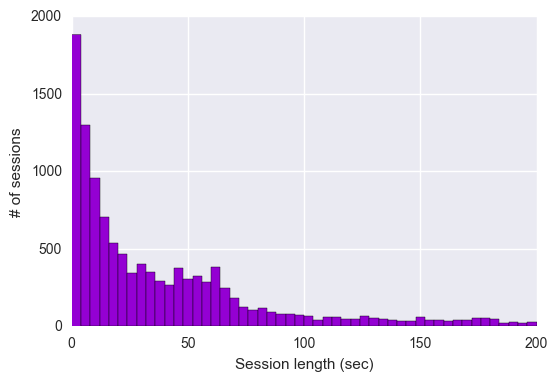

In [182]:
ax=train_data_10users['session_timespan'].hist(bins=50, range=(0,200),color='darkviolet').set_xlim((0,200))
plt.xlabel('Session length (sec)')
plt.ylabel('# of sessions')

### 2.2 Histogram of unique sites distribution

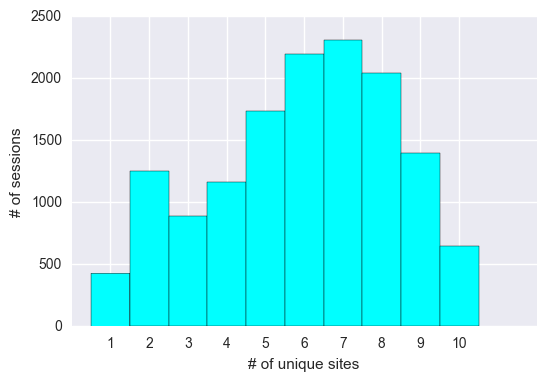

In [185]:
train_data_10users['#unique_sites'].hist(bins=10, range=(0.5,10.5),color='aqua')
plt.xticks(range(1,11))
plt.xlabel('# of unique sites')
plt.ylabel('# of sessions')

### 2.2.1 Histogram of unique sites distribution for each user

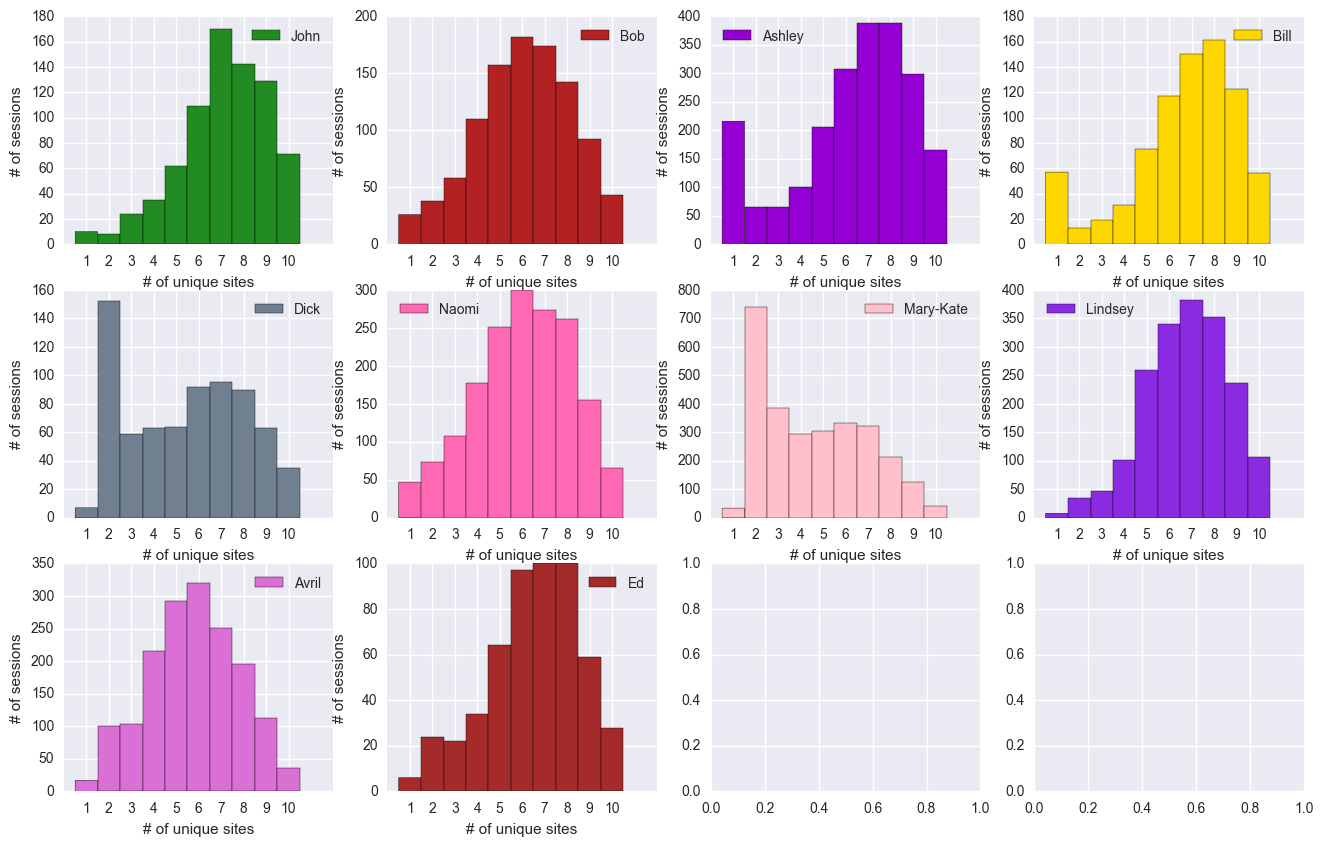

In [186]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    plt.subplot(3,4,idx+1)
    sub_df['#unique_sites'].hist(bins=10,range=(0.5,10.5),color=color_dic[id_name_dict[user]])
    plt.xlabel('# of unique sites')
    plt.ylabel('# of sessions')
    plt.legend([str(id_name_dict[user])],loc='best')
    plt.xticks(range(1,11))

### 2.3 Histogram of hours when session starts:

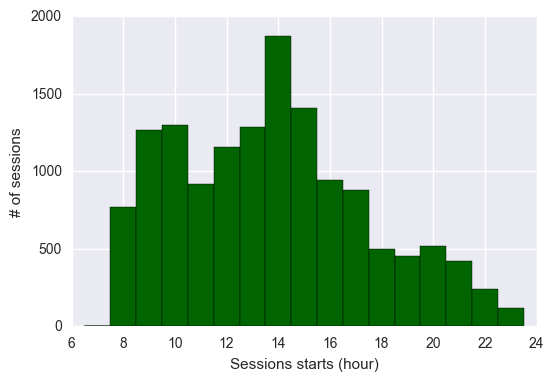

In [187]:
uniqueHours=np.unique(train_data_10users['start_hour'])
train_data_10users['start_hour'].hist(bins=len(uniqueHours),range=(min(uniqueHours)-0.5,min(uniqueHours)-0.5+len(uniqueHours)),color='darkgreen')
plt.xlabel('Sessions starts (hour)')
plt.ylabel('# of sessions')

### 2.3.1 Histograms of hours when session starts for each user:

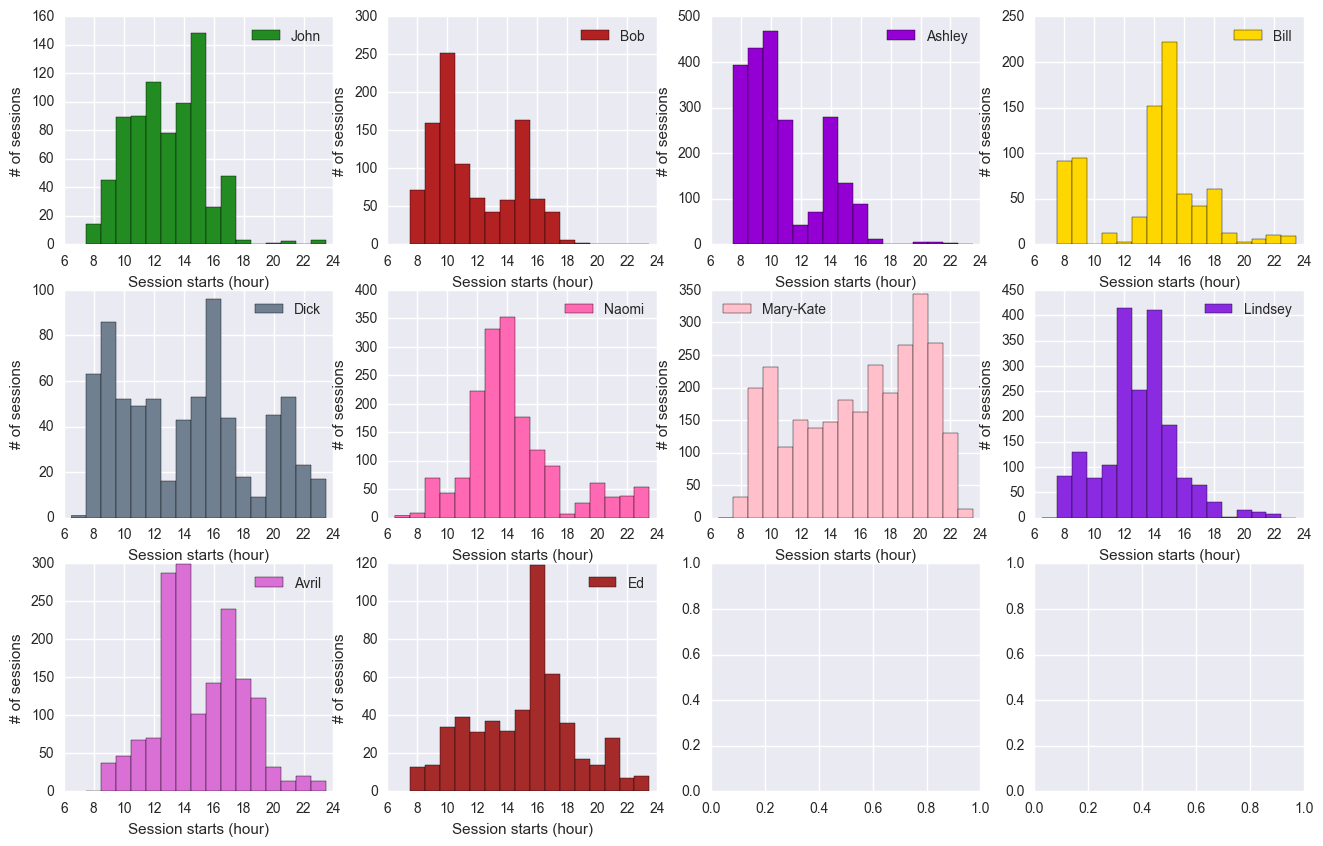

In [190]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    plt.subplot(3,4,idx+1)
    uniqueHours=np.unique(train_data_10users['start_hour'])
    sub_df['start_hour'].hist(bins=len(uniqueHours),range=(min(uniqueHours)-0.5,min(uniqueHours)-0.5+len(uniqueHours)),color=color_dic[id_name_dict[user]])
    plt.xlabel('Session starts (hour)')
    plt.ylabel('# of sessions')
    plt.legend([str(id_name_dict[user])],loc='best')

### 2.4 Session start day of the week distribution:

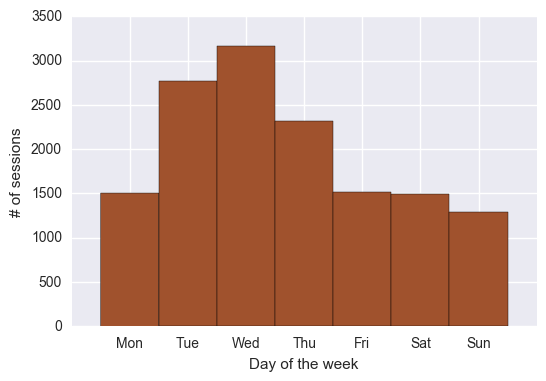

In [193]:
ax=train_data_10users['day_of_week'].hist(bins=7,range=(-0.5,6.5),color='sienna')
plt.ylabel('# of sessions')
plt.xlabel('Day of the week')
plt.xticks(range(7))
ax.set_xticklabels( ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

### 2.4.1 Session start day of the week distribution for each of 10 users:

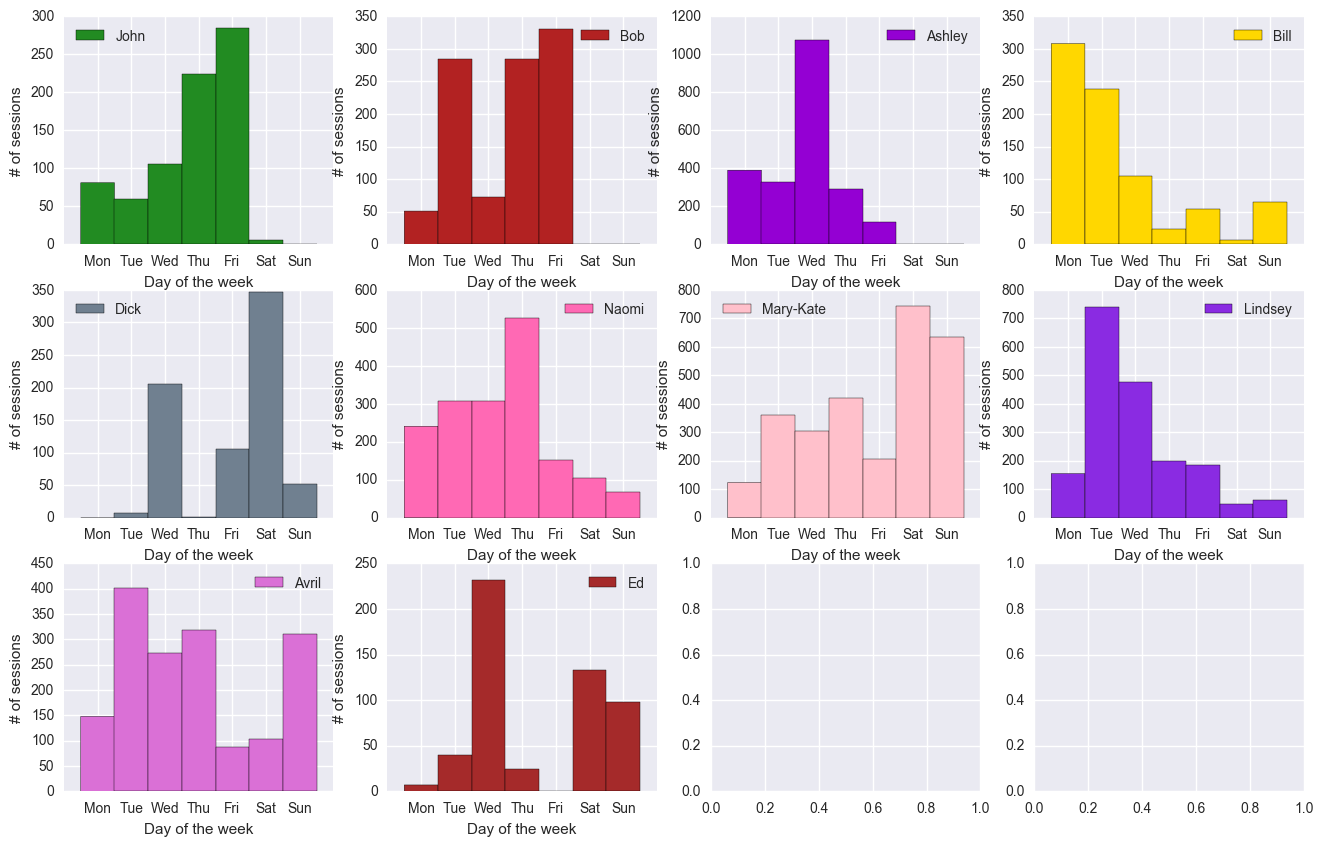

In [194]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    plt.subplot(3,4,idx+1)
    ax=sub_df['day_of_week'].hist(bins=7,range=(-0.5,6.5),color=color_dic[id_name_dict[user]])
    plt.legend([str(id_name_dict[user])],loc='best')
    plt.ylabel('# of sessions')
    plt.xlabel('Day of the week')
    plt.xticks(range(7))
    ax.set_xticklabels( ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

### 2.5 Conclusions based on plots:

1. Dick and Mary-Kate mostly visit small number of unique sites (maximum corresponds to 2 sites in a session). At the same time others visit 6-8 unique sites. Ashley and Bill also have a local minimum corresponding to 1 site.  

2. Bob and Ashley mostly use internet in the morning, while Mary-Kate has activity peak in the evening. Activity of others mostly peaks in the middle of the day.

3. Mary-Kate uses internet more on the weekends, while John, Bob and Ashley almost do not use internet on the weekends. Dick does not use internet on Mon & Thu; Ed on Mon & Fri. John has an activity peak in Thu-Fri, Bob - on Tue, Thu & Fri, Ashly - on Wed, Bill - on Mon-Tue, Dick on Wed & Sat, Naomi - on Thu, Linsey - on Tue, Avril - on Tue, Wed, Thu, Sun, and Ed - on Wed.

This differences in behavior may help us to identify the users!

# 3. Additional features

### 3.1 Let's add 2 more features: min and max time spent at a website in a given sessions

In [196]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'min_duration','max_duration', 'user_id']

In [201]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):

    files_grabbed=glob.glob(path_to_csv_files+'user*.csv')
    #print files_grabbed
    sessionInfo=[]
    session_id=0
    
    with open(site_freq_path, 'rb') as f:
        siteDict = pickle.load(f)
    siteDict['Empty'] = (0,0)
    
    for i in tqdm(range(len(files_grabbed))):
        
        data=pd.read_csv(files_grabbed[i])
        fileLength=data.shape[0]
        #print fileLength
        data['user']=int(files_grabbed[i][-8:-4])
        tmp=[(datetime.strptime(data.timestamp[i+1], '%Y-%m-%d %H:%M:%S')-
                datetime.strptime(data.timestamp[i], '%Y-%m-%d %H:%M:%S')).seconds for i in range(fileLength-1) ]
        #print fileLength,len(tmp)
        #print tmp
        data['duration']=0
        #print data['duration'][:-1]
        data['duration'][:-1]=tmp
        #data['duration'][-1]=-1
        #print data['duration']
        
        nSessions=int( (data.shape[0]+window_size-0.01) / window_size )
        addRows=int((nSessions-1)*window_size+session_length-fileLength)
        d2=np.reshape([[  '' ,  'Empty', data.ix[0,2],0 ]*addRows],(addRows,4))
        df2=pd.DataFrame(d2, columns = ['timestamp', 'site','user','duration'])
        data=data.append(df2,ignore_index=True)

        for j in range(nSessions):
            #tt=np.zeros(len(feature_names), dtype=np.int)
            #times_tmp=np.empty(session_length, dtype="S19")
            #for k in range(session_length):
            #    tt[k]=siteDict[data.ix[j*window_size+k,1]][0]
                #print j,k,data.ix[j*window_size+k,0]
             #   times_tmp[k]=data.ix[j*window_size+k,0]
            
            tt=[siteDict[data.ix[j*window_size+k,1]][0] for k in range(session_length)]

            dur=np.array([data.ix[j*window_size+k,3] for k in range(session_length)],dtype=np.int)
            #print i,j, k, data.ix[j*window_size+k,1]
            #datetime.strptime(data.ix[j*window_size+k,0], '%Y-%m-%d %H:%M:%S')
            #times_tmp=filter(None, times_tmp) 
            times_tmp=np.array([data.ix[j*window_size+k,0] for k in range(session_length)], dtype="S19")
            times_tmp=[datetime.strptime(el, '%Y-%m-%d %H:%M:%S') for el in filter(None, times_tmp)]
            
            dur1=[ x1 for x1 in dur if x1>0]
            #print dur,dur1
            if not dur1:
                dur1=[0]
                #print dur1

            tt.extend([int((max(times_tmp)-min(times_tmp)).total_seconds()), #k+1
                       len(   np.unique([ x1 for x1 in tt if x1>0] )  ),
                       min(times_tmp).hour,
                       min(times_tmp).weekday(), 
                       min(dur1),
                       max(dur1),
                       int(data.ix[j*window_size+k,2])
                      ]) 
            sessionInfo.append(tt)
        session_id=session_id+1

    return pd.DataFrame(sessionInfo,columns = feature_names)

In [202]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users/'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████| 10/10 [01:32<00:00,  8.96s/it]


Wall time: 1min 32s


In [204]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,min_duration,max_duration,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,1,20,31
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,1,163,31
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,1,242,31
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,1,25,31
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,1,1,31


### 3.2 Plot new features

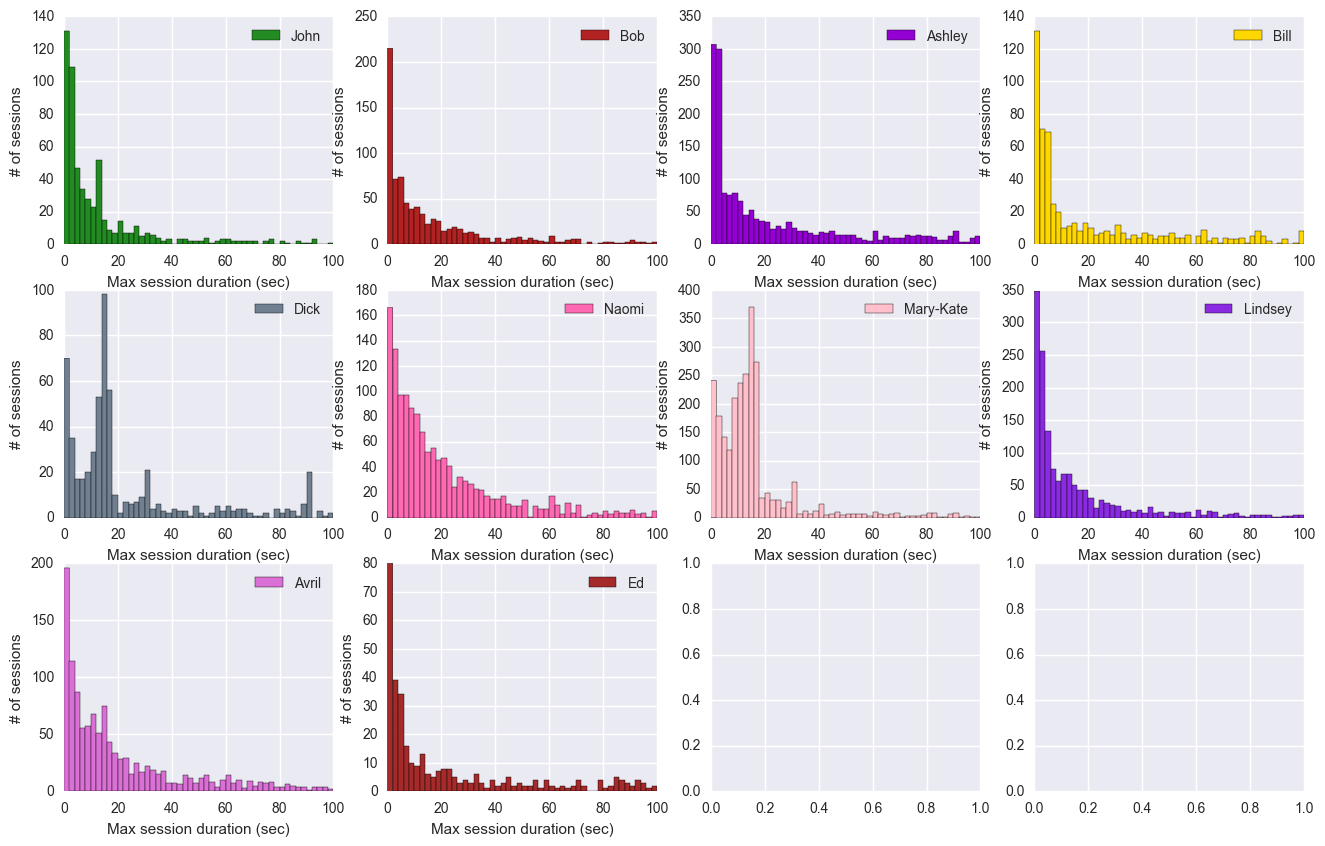

In [206]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    plt.subplot(3,4,idx+1)
    uniqueHours=np.unique(new_features_10users['max_duration'])
    sub_df['max_duration'].hist(bins=50,range=(0,100),color=color_dic[id_name_dict[user]])
    plt.xlabel('Max session duration (sec)')
    plt.ylabel('# of sessions')
    plt.legend([str(id_name_dict[user])],loc='best')

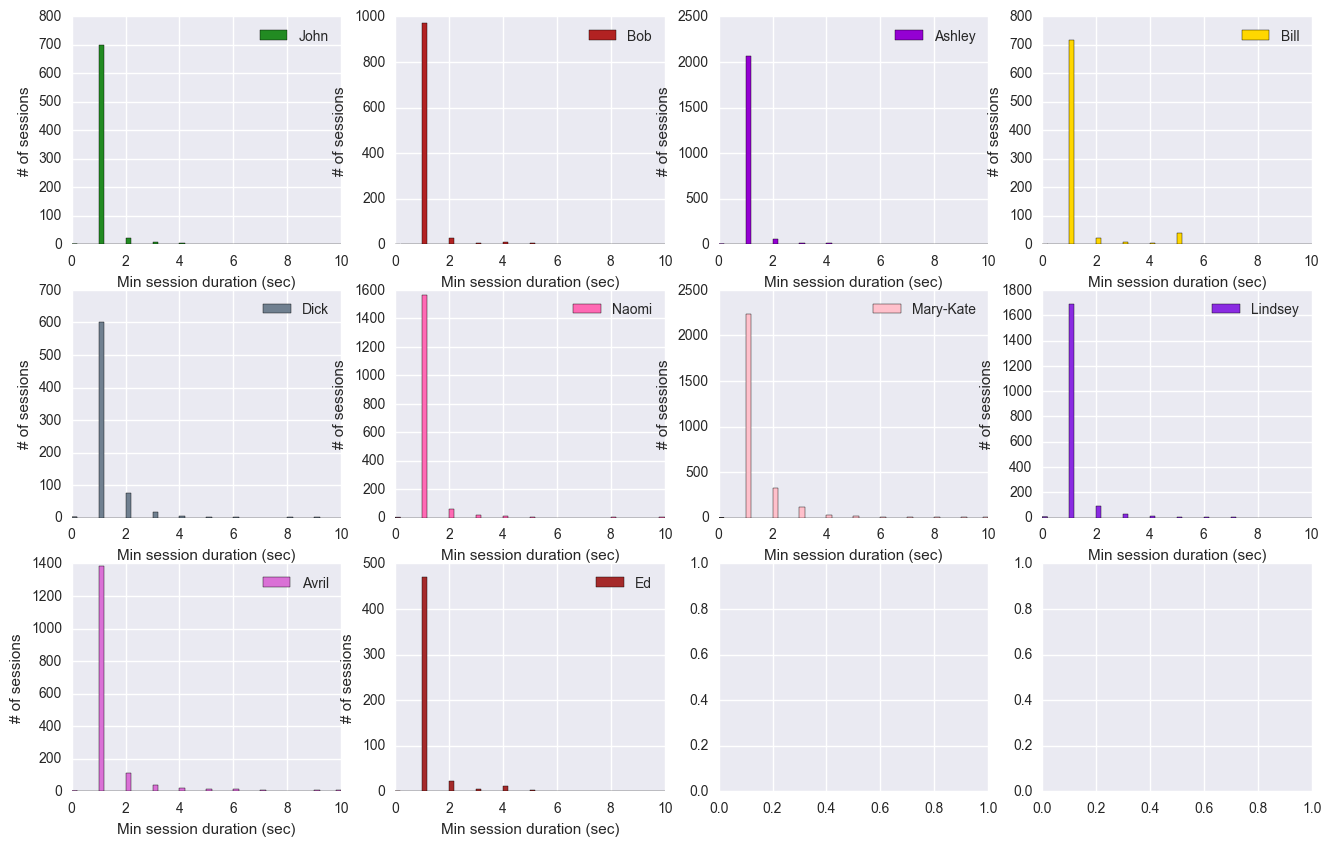

In [207]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    plt.subplot(3,4,idx+1)
    uniqueHours=np.unique(new_features_10users['min_duration'])
    sub_df['min_duration'].hist(bins=50,range=(0,10),color=color_dic[id_name_dict[user]])
    plt.xlabel('Min session duration (sec)')
    plt.ylabel('# of sessions')
    plt.legend([str(id_name_dict[user])],loc='best')

### 3.3 Analysis:

One can see that Dick and Mary-Kate, who predominantly visit small number of websites also tend to spend more time on a given website. They have a peak in in max session duration around 15 sec, while for others simple monotonic fall off is observed. Dick and Mary-Kate also have somewhat slower fall off of the min session duration compared to others. Therefore, these features may turn out to be useful in user identification.

# 4. Comparison of classification algorithms

### Several classification algorithms will be compared below using the data from 10 users.

**Load data from 10 users prepared earlier:**

In [8]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

** Split data into 2 parts: 1st we'll use for cross-valiadation, 2nd for estimation of the model trained after cross-validation**

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Define cross-validation: 3-fold, with shuffle, random state=17 for reproducibility**

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

### 4.1 KNeighborsClassifier with 100 nearest neighbours

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=100,n_jobs=-1)
knn.fit(X_train,y_train)
print 'Training accuracy: ',round(cross_val_score(knn, X_train, y_train, scoring = 'accuracy',cv=skf).mean(),3)
print 'Validation accuracy: ', round(knn.score(X_valid, y_valid),3)

Training accuracy:  0.562
Validation accuracy:  0.584


### 4.2 RandomForestClassifier with 100 trees

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier (n_estimators=100,oob_score=True,n_jobs=-1,random_state=17)
forest.fit(X_train,y_train)
print 'Training accuracy: ', round(forest.oob_score_,3) 
print 'Validation accuracy: ', round(forest.score(X_valid,y_valid),3)

Training accuracy:  0.723
Validation accuracy:  0.735


### 4.3 LogisticRegression

In [18]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logit = LogisticRegression(n_jobs=-1,random_state=17 )
print 'Training accuracy: ', round(cross_val_score(logit, X_train, y_train, scoring = 'accuracy',cv=skf).mean(),3)
logit.fit(X_train,y_train)
print 'Validation accuracy: ', round(logit.score(X_valid,y_valid),3)

Training accuracy:  0.763
Validation accuracy:  0.782


**Using LogisticRegressionCV let's find optimal regularization parameter C first searching in a wide range of values**

In [19]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)
logit_mean_cv_scores1=[]
for i in range(10):
    logit_grid_searcher1 = LogisticRegressionCV(Cs=[logit_c_values1[i]],multi_class='multinomial',scoring='accuracy',random_state=17,n_jobs=-1)
    logit_mean_cv_scores1.append(cross_val_score(logit_grid_searcher1, X_train, y_train, scoring = 'accuracy',cv=skf).mean())

Wall time: 1min 59s


**Find best fraction of accurate predictions and corresponding C value**

In [24]:
print 'Best cross-validation score: ',round(max(logit_mean_cv_scores1),3),'\nCorresponding C value: ',round(logit_c_values1[logit_mean_cv_scores1.index(max(logit_mean_cv_scores1))],3)

Best cross-validation score:  0.763 
Corresponding C value:  4.642


**Repeat search for narrower range of C values**

In [25]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)
logit_mean_cv_scores2=[]
for i in range(20):
    logit_grid_searcher2 = LogisticRegressionCV(Cs=[logit_c_values2[i]],multi_class='multinomial',scoring='accuracy',random_state=17,n_jobs=-1)
    logit_mean_cv_scores2.append(cross_val_score(logit_grid_searcher2, X_train, y_train, scoring = 'accuracy',cv=skf).mean())

Wall time: 6min 27s


**Again, find best fraction of accurate predictions and corresponding C value:**

In [27]:
print 'Best cross-validation score: ',round(max(logit_mean_cv_scores2),3),'\nCorresponding C value: ',round(logit_c_values2[logit_mean_cv_scores2.index(max(logit_mean_cv_scores2))],3)

Best cross-validation score:  0.764 
Corresponding C value:  3.0


**Plot accuracy as a function of regulariation parameter C:**

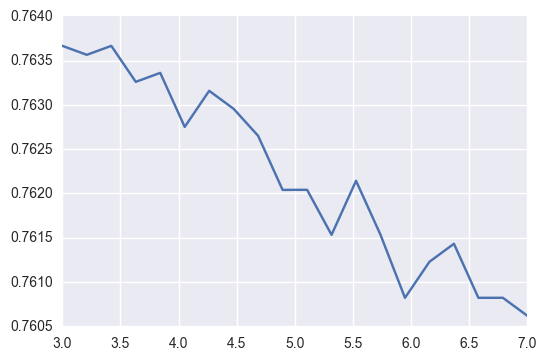

In [30]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

**Validation accuracy for best C:**

In [31]:
logit2 = LogisticRegression(C=3.,n_jobs=-1,random_state=17 )
logit2.fit(X_train,y_train)
print 'Validation accuracy',round(logit2.score(X_valid,y_valid),3)

Validation accuracy 0.785


### 4.4 LinearSVC

In [35]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=1.,random_state=17)
print 'Training accuracy: ', round(cross_val_score(svm, X_train, y_train, scoring = 'accuracy',cv=skf).mean(),3)
svm.fit(X_train,y_train)
print 'Validation accuracy: ', round(svm.score(X_valid,y_valid),3)

Training accuracy:  0.757
Validation accuracy:  0.777


**Using GridSearchCV let's find optimal regularization parameter C**

In [39]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}
svm_grid_searcher1 = GridSearchCV(svm,svm_params1)
svm_grid_searcher1.fit(X_train, y_train)
print round(svm_grid_searcher1.best_score_,3)

0.692
Wall time: 53.2 s


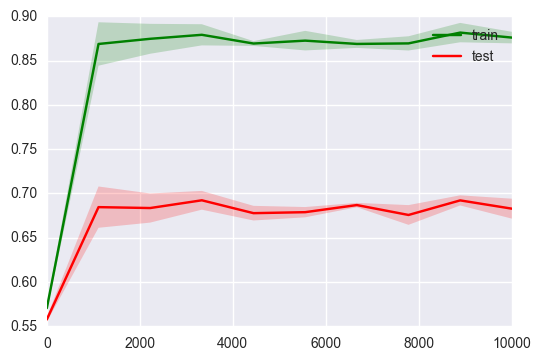

In [38]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()
    
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Repeat the search in a narrower range**

In [60]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
svm_grid_searcher2 = GridSearchCV(svm,svm_params2)
svm_grid_searcher2.fit(X_train, y_train)
print 'Best training accuracy: ',round(svm_grid_searcher2.best_score_,3)

Best training accuracy:  0.766
Wall time: 1min 39s


**Plot train/test accuracy curves as a function of regularization parameter:**

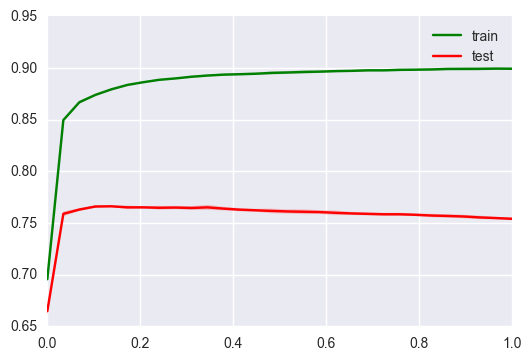

In [62]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

**Compute accuracy on validation dataset:**

In [64]:
svm = LinearSVC(C=svm_grid_searcher2.best_estimator_.C,random_state=17)
svm.fit(X_train,y_train)
print 'Validation accuracy for best C=',round(svm_grid_searcher2.best_estimator_.C,3),': ',round(svm.score(X_valid,y_valid),3)

Validation accuracy for best C= 0.139 :  0.782


### 4.5 Summarize results from different classifiers:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">Classifier</th>
    <th class="tg-031e">Training Accuracy</th>
    <th class="tg-031e">Validation Accuracy</th>
  </tr>
  <tr>
    <td class="tg-031e">KNeighborsClassifier </td>
    <td class="tg-031e">0.562</td>
    <td class="tg-031e">0.584</td>
  </tr>
  <tr>
    <td class="tg-yw4l">RandomForrest</td>
    <td class="tg-yw4l">0.723</td>
    <td class="tg-yw4l">0.735</td>
  </tr>
  <tr>
    <td class="tg-031e">LogisticRegression</td>
    <td class="tg-031e">0.764</td>
    <td class="tg-031e">0.785</td>
  </tr>
  <tr>
    <td class="tg-031e">LinearSVC</td>
    <td class="tg-031e">0.766</td>
    <td class="tg-031e">0.782</td>
  </tr>
</table>

**One can see that the last 2 classifiers LogisticRegression and LinearSVM give the best performance.**

### 4.6 Session length and session window parameter optimization 

**Let's optimize session_length and window_size parameters for LinearSVC algorithm, which shown the best accuracy on the training dataset.** 

In [98]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_10users_pkl:
        X_sparse_10users = pickle.load(X_sparse_10users_pkl)
    
    with open(path_to_y_pickle, 'rb') as y_10users_pkl:
        y_10users = pickle.load(y_10users_pkl)
    
    #print X_sparse_10users.shape
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y_10users)
    cvs=cross_val_score(estimator, X_train, y_train, scoring = 'accuracy',cv=cv).mean()
    estimator.fit(X_train,y_train)
    vsc=estimator.score(X_valid,y_valid)
    return cvs,vsc

**Let's perform estimations for different parameters using training sets created earlier:**

In [104]:
%%time
estimator = svm_grid_searcher2.best_estimator_
num_users=10

print  'SessionLength / WindowSize --- Training Accuracy / Validation Accuracy'
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA,'X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA,'y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        cvs,vsc=model_assessment(estimator,path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print session_length,' / ',window_size,' --- ',round(cvs,3),' / ',round(vsc,3)
    

SessionLength / WindowSize --- Training Accuracy / Validation Accuracy
15  /  10  ---  0.826  /  0.84
10  /  10  ---  0.764  /  0.782
15  /  7  ---  0.85  /  0.854
10  /  7  ---  0.8  /  0.808
7  /  7  ---  0.751  /  0.763
15  /  5  ---  0.871  /  0.876
10  /  5  ---  0.816  /  0.825
7  /  5  ---  0.773  /  0.787
5  /  5  ---  0.723  /  0.737
Wall time: 37.2 s


**One can see that results are better for longer sessions and for a given session length they are better for a shorter session window size. The best results so far for a data set of 10 users correspond to  LinearSVC estimator and session length of 15 and window size of 5.**

### 4.7 Data from 150 users

** Let's now take a look at the data from 150 users. Multi-class classification accuracy drops for the 150 users dataset as shown below:**

In [105]:
%%time
estimator = svm_grid_searcher2.best_estimator_
num_users=150

print  'SessionLength / WindowSize --- Training Accuracy / Validation Accuracy'
for window_size, session_length in [(5,5), (7,7), (10,10)]:
        path_to_X_pkl = os.path.join(PATH_TO_DATA,'X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA,'y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        cvs,vsc=model_assessment(estimator,path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print session_length,' / ',window_size,' --- ',round(cvs,3),' / ',round(vsc,3)
    

SessionLength / WindowSize --- Training Accuracy / Validation Accuracy
5  /  5  ---  0.409  /  0.423
7  /  7  ---  0.437  /  0.454
10  /  10  ---  0.462  /  0.484
Wall time: 26min 20s


### 4.8 However, one can identify individual user fairly well if he uses one-vs-rest classifier:

In [107]:
# load the data and split into training and validation datasets
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)
    
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                  y_150users, test_size=0.3, 
                                                 random_state=17, stratify=y_150users)

In [108]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[3.],multi_class='ovr',scoring='accuracy',random_state=17,n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 15min 10s


In [117]:
cv_scores_by_user = []
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user.append(logit_cv_150users.scores_[user_id].mean())
    #print user_id
print 'Mean accuracy of single user identification: ',np.mean(cv_scores_by_user)

Mean accuracy of single user identification:  0.99458390975


## Indeed accuracy of a single user identification using one-vs-rest classifier is very high.

## 5. SDGClassifier and Kaggle competition

**Below, we will employ Scikit-learn SGDClassifier to a data set of 400 users from [Kaggle competition](https://inclass.kaggle.com/c/identify-me-if-you-can4). SDGClassifier works significanly faster on large data sets than algolrithms tested above, since it employs stochastic gradient descent.**

In [5]:
#Load the data
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),index_col='session_id')
print '# of unique users:', train_df['user_id'].nunique()
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),index_col='session_id')
train_test_df = pd.concat([train_df, test_df])
# only use sites for prediction
train_test_df_sites = train_test_df[['site1', 'site2', 'site3', 
                                     'site4','site5', 
                                     'site6','site7', 'site8', 
                                     'site9', 'site10']].fillna(0).astype('int')

# of unique users: 400


In [6]:
#Convert to CSR matrix
def convert_to_csr(x):
    ccount, ccol, rrow =[], [], []
    for j in range(len(x)):
        col1,count1 = np.unique(x[j,:], return_counts=True)
        ccount.extend(count1)
        ccol.extend(col1)
        row1=[j]*len(col1)
        rrow.extend(row1)
    csrOutput=csr_matrix((ccount,(rrow,ccol)),(len(x),(np.max(x)+1)))
    return csrOutput[:,1:].astype(int)

X_train_test_sparse = convert_to_csr(train_test_df_sites.values)

X_train_sparse = X_train_test_sparse[:train_df.shape[0],:]
X_test_sparse = X_train_test_sparse[train_df.shape[0]:,:]
y = train_df.user_id.values

In [7]:
# Split training data set into 2 parts (7/3 ratio) and stratify:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y, test_size=0.3, 
                                                     random_state=17, stratify=y)

### 5.1 Let's try SGDClassifier with log and hinge loss function (corresponding to logistic regression and linear SVM) to see which one gives the best performance:

In [8]:
%%time
from sklearn.linear_model import SGDClassifier

sgd_logit = SGDClassifier(loss='log',n_jobs=-1,random_state=17)
sgd_logit.fit(X_train, y_train)
sgd_svm = SGDClassifier(loss='hinge',n_jobs=-1,random_state=17)
sgd_svm.fit(X_train, y_train)
logit_valid_pred = sgd_logit.predict(X_valid)
svm_valid_pred = sgd_svm.predict(X_valid)
print 'Logistic regression training accuracy:',round(sgd_logit.score(X_train, y_train),3)
print 'Logistic regression validation accuracy:',round(accuracy_score(logit_valid_pred,y_valid),3)
print 'SVM training accuracy: ',round(sgd_svm.score(X_train, y_train),3)
print 'SVM validation accuracy:',round(accuracy_score(svm_valid_pred,y_valid),3)
logit_test_pred = sgd_logit.predict(X_test_sparse)

Logistic regression training accuracy: 0.354
Logistic regression validation accuracy: 0.302
SVM training accuracy:  0.378
SVM validation accuracy: 0.295
Wall time: 31.4 s


** One can see that although SVM achieved better training accuracy than logistic regression (0.378 vs. 0.354), logistic regression gives better validation accuracy (0.302 vs. 0.295). Therefore, logistic regression was used for making a prediction on the test dataset and resulted in 0.17292 score in the [Kaggle competition](https://inclass.kaggle.com/c/identify-me-if-you-can4/leaderboard). **

### 5.2 Optimization of the session length allows to further improve accuracy

**Approach described in the section 5.1 has been further optimized below to explore how accuracy of prediction depends on the window size. New training sets for window_size-s in the range bettween 2 and 10 has been formed using the approach below (some details are omitted)** 

In [ ]:
train_df  = prepare_train(os.path.join(PATH_TO_DATA, 'train'), 
site_dict_path=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
session_length=10, window_size=4) #2,3,4,5,6,10
train_df = train_df.sample(frac=1, random_state=17)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')
train_test_df = pd.concat([train_df, test_df])
train_test_df_sites = train_test_df[['site1', 'site2', 'site3', 
                                     'site4','site5', 
                                     'site6','site7', 'site8', 
                                     'site9', 'site10']].fillna(0).astype('int')
X_train_test_sparse = convert_to_csr(train_test_df_sites.values)
X_train_sparse = X_train_test_sparse[:train_df.shape[0],:]
X_test_sparse = X_train_test_sparse[train_df.shape[0]:,:]
y = train_df.user_id.values
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y, test_size=0.3, 
                                                     random_state=17, stratify=y)

** Window size optimization (some details are omitted) shown that window_size=4 gave the best performance and resulted in the 0.17529 score in the [Kaggle competition](https://inclass.kaggle.com/c/identify-me-if-you-can4/leaderboard), which is an improvement compared to the result achieved in Section 5.1.**

# 6. Vowpal Wabbit Library

** In this section we'll employ another powerful tool, a Vowpal Wabbit library, which allows to further improve accuracy. In addition we'll use a tf-idf transformation.**

**Transform class labels to VW format**

In [9]:
from sklearn.preprocessing import LabelEncoder
class_encoder = LabelEncoder().fit(y)
y_for_vw = class_encoder.transform(y) + 1

** Since analysis of the features describing user behavior has shown that some users have preference for attending certain websites, we'll perform a tf-idf transformation of the data. tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using tf-idf instead of the raw frequencies of occurrence of a website for a given user is to scale down the impact of websites that occur very frequently for all the users and that are hence empirically less informative than websites that occur for a small fraction of users. **

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf=TfidfTransformer(sublinear_tf=True)

X_train_sparse_tf=tfidf.fit_transform(X_train_sparse)
X_test_sparse_tf=tfidf.transform(X_test_sparse)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse_tf, y_for_vw, test_size=0.3, 
                                                     random_state=17, stratify=y_for_vw)

In [12]:
def sparse_matrix_to_vw(X_sparse, y=None, out_file='tmp.vw'):   
    if y is None:
        y=[1] * np.shape(X_sparse)[0]
    
    with open(out_file, 'w') as vw_train_data:
        for j in range(np.shape(X_sparse)[0]):
            X_tmp=X_sparse[j,:]
            ij=X_tmp.nonzero()
            s=str(y[j])+' | sites'
            for i in range(np.shape(ij)[1]):
                s=s+' '+str(ij[1][i]+1)+':'+str(X_tmp[ij[0][i],ij[1][i]])
            vw_train_data.write(s+'\n')
        print j

In [13]:
%%time
sparse_matrix_to_vw(X_train, y_train, os.path.join(PATH_TO_DATA, 'train_part.vw'))
sparse_matrix_to_vw(X_valid, y_valid, os.path.join(PATH_TO_DATA, 'valid.vw'))
sparse_matrix_to_vw(X_train_sparse_tf, y_for_vw, os.path.join(PATH_TO_DATA, 'train.vw'))
sparse_matrix_to_vw(X_test_sparse_tf, out_file=os.path.join(PATH_TO_DATA, 'test.vw'))

127954
54837
182792
46472
Wall time: 2min 40s


In [14]:
train_part_vw = os.path.join(PATH_TO_DATA, 'train_part.vw')
valid_vw = os.path.join(PATH_TO_DATA, 'valid.vw')
train_vw = os.path.join(PATH_TO_DATA, 'train.vw')
test_vw = os.path.join(PATH_TO_DATA, 'test.vw')
model = os.path.join(PATH_TO_DATA, 'vw_model.vw')
model_full = os.path.join(PATH_TO_DATA, 'vw_model_full.vw')
pred = os.path.join(PATH_TO_DATA, 'vw_pred.csv')

### 6.1 First check VW library on a subset of data:

In [18]:
# train on subset
!vw  --oaa 400 -d $train_part_vw -f $model -c -k --random_seed 17 --passes 30 -b 26 --loss_function logistic --quiet

In [19]:
# save predictions
!vw -i $model -t -d $valid_vw -p vw_valid_pred.csv --quiet

In [20]:
# compare wih predictions on the validation data set
vw_valid_pred = pd.read_csv('vw_valid_pred.csv',header=None)
acc_vw=accuracy_score(y_valid,vw_valid_pred) #.loc[:,0]
print 'Validation accuracy (trained on subset): ',round(acc_vw,3)

Validation accuracy (trained on subset):  0.38


** One can already see an improvement compared to the SGDClassifier!**

### 6.2 Now let's train on the whole dataset:

In [21]:
!vw  --oaa 400 -d $train_vw -f $model_full -c -k --random_seed 17 --passes 30 -b 26 --loss_function logistic  --quiet

In [22]:
!vw -i $model_full -t -d $valid_vw -p vw_valid_pred_full.csv --quiet
vw_valid_pred_full = pd.read_csv('vw_valid_pred_full.csv',header=None)
acc_vw_full=accuracy_score(y_valid,vw_valid_pred_full) #.loc[:,0]
print 'Validation accuracy (trained on full dataset): ',round(acc_vw_full,3)

Validation accuracy (trained on full dataset):  0.508


**One can see that accuracy further improved!**

** Let's now make a prediction for Kaggle:**

In [23]:
!vw -i $model_full -t -d $test_vw -p vw_test_pred.csv --quiet

In [25]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [26]:
vw_pred = pd.read_csv('vw_test_pred.csv',header=None)
vw_subm = class_encoder.inverse_transform(vw_pred.loc[:,0]-1)
write_to_submission_file(vw_subm, 'VW_logit_test_pred_tfidf_logistic_50.txt')

** Using Vowpal Wabbit with tf-idf allowed to take the 1st place in the [Kaggle competition](https://inclass.kaggle.com/c/identify-me-if-you-can4/leaderboard)  with the score 0.20382 [user AlexeyK]. This is a clear improvement compared to SGDClassifier from Section 5.**

** Unfortunately, I have not been able to further improve VW performance on Kaggle test data by optimizing either window_size (as in Section 5) or adding other features. While accuracy on the training data set increased in many cases, the accuracy on the Kaggle test data set actually dropped. For example, changing window_size to 4 (as in Section 5) allowed to increase validation accuracy from 0.483 to 0.51, but the Kaggle score dropped. This could have been caused by over-training.
** 

# 7. Conclusions

** In this project we presented a method of user identification based on the data on series of web-pages sequentially visited by the user.**

The model using Vowpal Wabbit library with tf-idf transformation allowed to take the 1st place in the Kaggle competition [Kaggle competition](https://inclass.kaggle.com/c/identify-me-if-you-can4/leaderboard)  [user AlexeyK].

The accuracy of the model on 400 users is not very high. However, it is still significantly better than just the fixed constant classificator. Secondly, as was demonstarted in Section 4.5, one-vs-rest classifier accuracy is much higher.

The test data set used in the Kaggle competition is very tricky. While adding new features to the model could significantly improve its accuracy on the training data set it actually often led to lower score on the test data, which was probably caused by over-training.  

To further improve accuracy of the model one can:
* differently split sessions, for example, using time duration instead of fixed number of sites
* make sessions longer (this was shown to help in section 4). However, for Kaggle competition this requires a differently formed training data set, which was not available 
* add more weight to more recent data 